### Library

In [1]:
import re
import glob
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error, mean_squared_error
from scipy import stats
from scipy.stats import zscore, uniform, randint

### Dataset

In [2]:
df = pd.read_csv('C:/Users/Kayaki/ta_project/data/raw/data.csv')

### Data Preparation

In [3]:
# Mengubah nama kolom
df = df.rename(columns={
    'Model Pakaian': 'model',
    'Jenis Bahan': 'bahan',
    'Waktu Pengerjaan (hari)': 'waktu_pengerjaan',
    'Detail Tambahan': 'ornamen',
    'Harga Jasa (Rp)': 'harga_jasa'
})

In [4]:
# Merubah data pada kolom 'harga_jasa' menjadi numerik
def clean_price(price):
    return int(str(price).replace('Rp', '').replace('.', '').replace(',', '').strip()) if pd.notna(price) else None

df['harga_jasa'] = df['harga_jasa'].apply(clean_price)
df = df.dropna(subset=['harga_jasa'])

In [5]:
# Cek data unik pada tiap variabel kategori
for col in ['model', 'bahan', 'ornamen']:
    print(f"{col.title()}:\n", df[col].unique(), "\n")

Model:
 ['Blus' 'Gaun maxi' 'Gaun midi' 'Kebaya modern' 'Kebaya Tradisional'
 'Kebaya Modern' 'Maxi Dress' 'Midi Dress'] 

Bahan:
 ['Katun' 'Satin' 'Sifon' 'Sutra' 'Brokat'] 

Ornamen:
 ['-' 'renda' 'opneisel terbuka' 'payet aksen kecil' 'payet aksen sedang'
 'payet aksen besar' 'opneisel tertutup' 'payet  aksen kecil'
 'payet  motif sedang' 'renda ' 'payet motif sedang' 'bordir sedang'
 'bordir tempel' 'bordir kecil' 'payet motif  sedang' 'payet  aksen besar'
 'bordir besar' ' bordir kecil' 'payet motif besar' 'bordir  sedang'
 'bordir sedang ' 'bordir kecil ' 'bordir tempel ' 'payet aksen  sedang'
 ' bordir sedang' ' -' 'bordir  kecil' '- ' 'bordir besar '
 'bordir  besar ' 'bordir  sedang ' 'opneisel  tertutup'] 



In [6]:
# Standarisasi format variabel kategori
cat_cols = ['model', 'bahan', 'ornamen']

for col in cat_cols:
    df[col] = df[col].str.title().str.strip().str.replace(r'\s+', ' ', regex=True)

In [7]:
# Menyeragamkan penulisan data di kolom 'model' dan 'ornamen'
df.replace({
    'model': {
        'Gaun Midi': 'Midi Dress', 
        'Gaun Maxi': 'Maxi Dress'},
    'ornamen': {
        '-': 'None'
    }
}, inplace=True)

In [8]:
pd.concat([df.head(3), df.tail(3)])

,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
0,Blus,Katun,None,4,200000
1,Blus,Katun,Renda,7,175000
2,Blus,Satin,None,7,150000
1111,Midi Dress,Sutra,Renda,16,425000
1112,Midi Dress,Sutra,Payet Aksen Kecil,20,550000
1113,Midi Dress,Sutra,Opneisel Terbuka,20,450000


### Exploratory Data Analysis

In [9]:
#Informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   model             1114 non-null   object
 1   bahan             1114 non-null   object
 2   ornamen           1114 non-null   object
 3   waktu_pengerjaan  1114 non-null   int64 
 4   harga_jasa        1114 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 43.6+ KB


In [10]:
# Menampilkan baris duplikat
df.duplicated().sum()

np.int64(197)

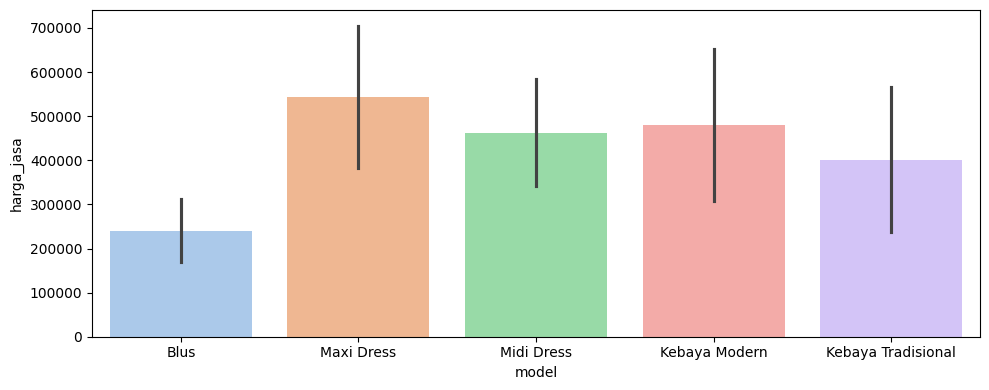

In [11]:
plt.figure(figsize=(10, 4))
sns.barplot(x='model', y='harga_jasa', hue='model', data=df, errorbar='sd', palette='pastel')
plt.tight_layout()
plt.show()

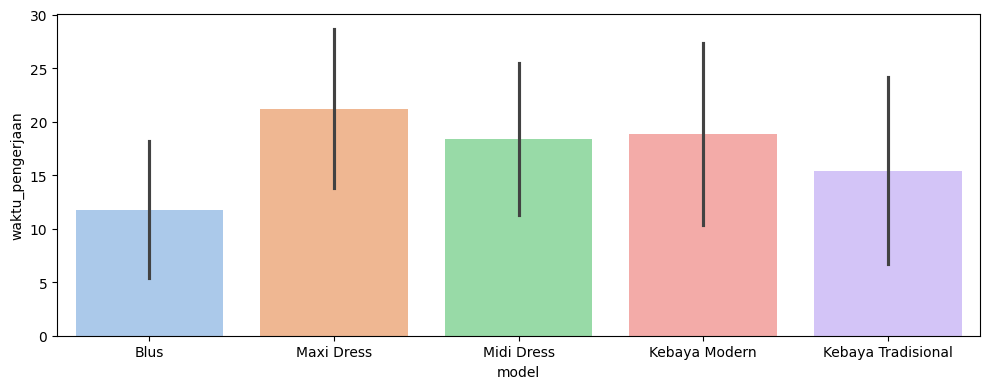

In [12]:
plt.figure(figsize=(10, 4))
sns.barplot(x='model', y='waktu_pengerjaan', hue='model', data=df, errorbar='sd', palette='pastel')
plt.tight_layout()
plt.show()

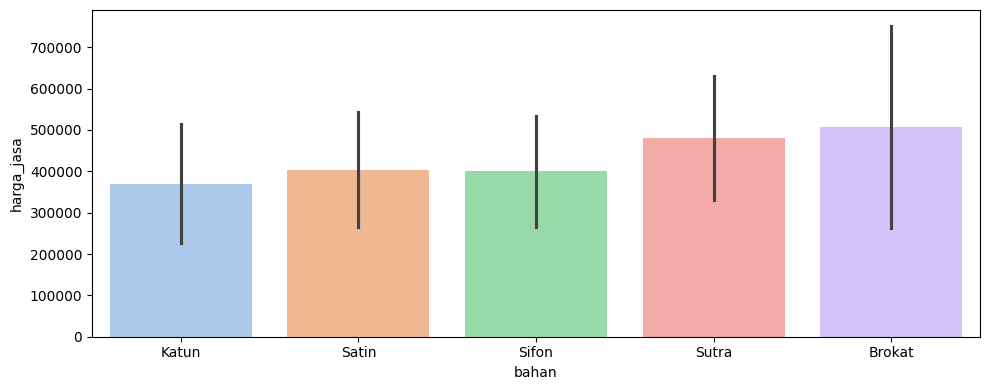

In [13]:
plt.figure(figsize=(10, 4))
sns.barplot(x='bahan', y='harga_jasa', hue='bahan', data=df, errorbar='sd', palette='pastel')
plt.tight_layout()
plt.show()

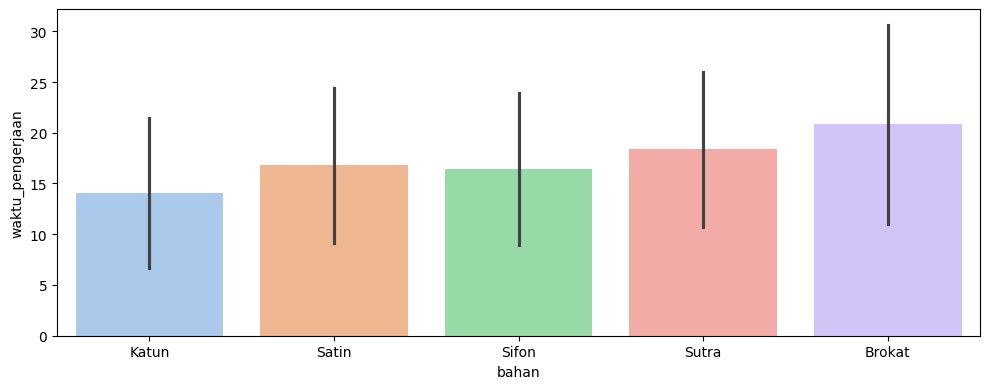

In [14]:
plt.figure(figsize=(10, 4))
sns.barplot(x='bahan', y='waktu_pengerjaan', hue='bahan', data=df, errorbar='sd', palette='pastel')
plt.tight_layout()
plt.show()

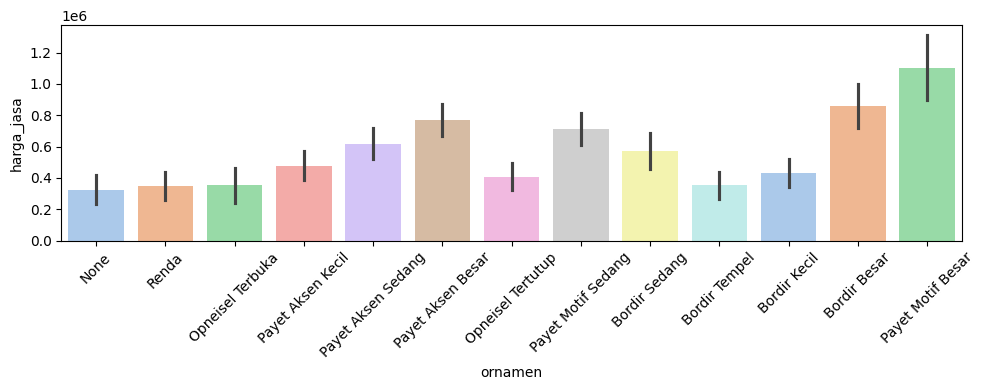

In [15]:
plt.figure(figsize=(10, 4))
sns.barplot(x='ornamen', y='harga_jasa', hue='ornamen', data=df, errorbar='sd', palette='pastel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

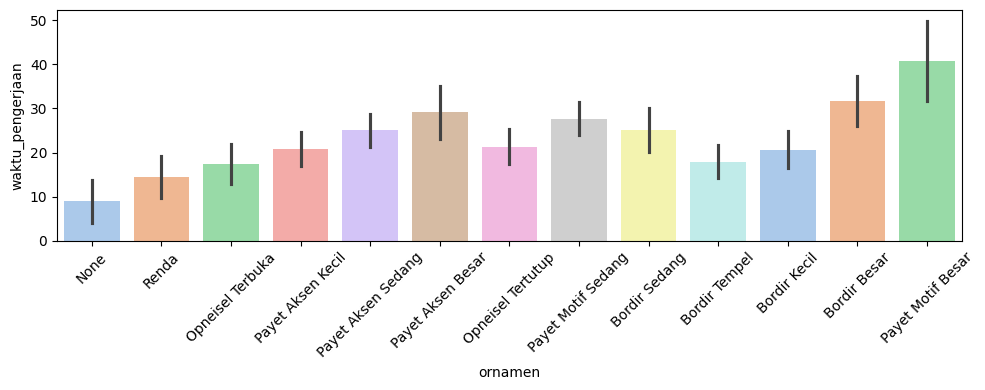

In [16]:
plt.figure(figsize=(10, 4))
sns.barplot(x='ornamen', y='waktu_pengerjaan', hue='ornamen', data=df, errorbar='sd', palette='pastel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='harga_jasa', ylabel='Count'>

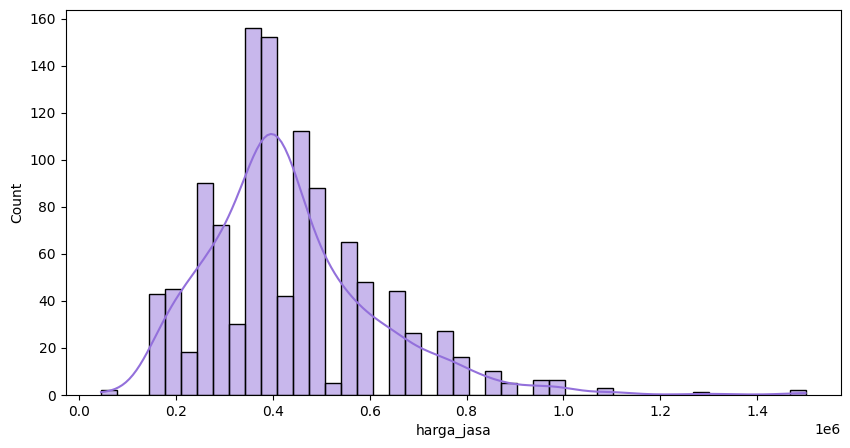

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df.harga_jasa, color="mediumpurple", kde=True)

<Axes: xlabel='harga_jasa', ylabel='Count'>

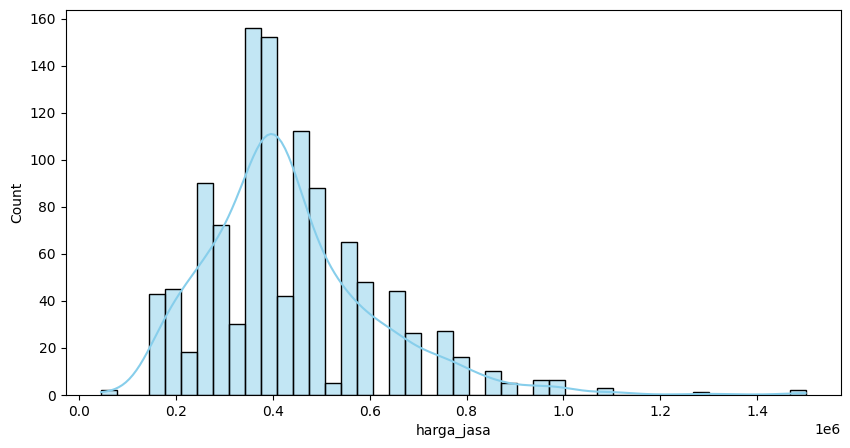

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df.harga_jasa, color="skyblue", kde=True)

### Preprocessing

In [19]:
# Menghapus duplikasi data
before = len(df)
df = df.drop_duplicates()
after = len(df)

if before > after:
    print(f"{before - after} data duplikat berhasil dihapus")
else:
    print("Tidak ada data duplikat yang ditemukan")

197 data duplikat berhasil dihapus


In [20]:
# Menangani outlier dengan Z-score
z_scores = abs(zscore(df[['waktu_pengerjaan', 'harga_jasa']]))
threshold = 4
df_no_outliers = df[(z_scores < threshold).all(axis=1)]
df = df_no_outliers

In [21]:
df[
    (df['model'] == 'Kebaya Tradisional') & 
    (df['bahan'] == 'Brokat') & 
    (df['ornamen'] == 'None')
]

,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
107,Kebaya Tradisional,Brokat,None,14,350000
220,Kebaya Tradisional,Brokat,None,2,300000
221,Kebaya Tradisional,Brokat,None,8,250000
480,Kebaya Tradisional,Brokat,None,2,400000
481,Kebaya Tradisional,Brokat,None,12,350000
617,Kebaya Tradisional,Brokat,None,6,250000
778,Kebaya Tradisional,Brokat,None,15,250000
914,Kebaya Tradisional,Brokat,None,3,300000
1039,Kebaya Tradisional,Brokat,None,4,300000


### Transformasi

In [22]:
# Pemisahan fitur dan target
X = df[['model', 'bahan', 'ornamen']]
y = df[['waktu_pengerjaan', 'harga_jasa']]

In [23]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

# Menampilkan jumlah data
print("Jumlah data latih:", len(train_set))
print("Jumlah data uji:", len(test_set))

Jumlah data latih: 731
Jumlah data uji: 183


In [25]:
# Menampilkan contoh data latih
pd.concat([train_set.head(3), train_set.tail(3)])

,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
946,Maxi Dress,Katun,Bordir Besar,30,900000
25,Midi Dress,Sutra,None,14,350000
84,Midi Dress,Brokat,Opneisel Terbuka,18,375000
1019,Kebaya Modern,Katun,None,6,350000
496,Kebaya Tradisional,Satin,Payet Aksen Kecil,20,500000
102,Kebaya Modern,Sifon,Opneisel Tertutup,18,400000


In [26]:
# Menampilkan contoh data uji
print("Contoh data uji:")
pd.concat([test_set.head(3), test_set.tail(3)])

Contoh data uji:


,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
426,Midi Dress,Sutra,Payet Aksen Kecil,18,550000
1010,Blus,Sutra,None,15,200000
398,Maxi Dress,Sutra,Payet Aksen Sedang,30,750000
678,Maxi Dress,Sutra,Bordir Kecil,22,600000
1049,Kebaya Tradisional,Satin,None,6,300000
821,Maxi Dress,Sifon,Payet Aksen Kecil,20,500000


In [27]:
# One-hot encoding
trans = ColumnTransformer(
    transformers=[
        ('coder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

In [28]:
# Terapkan transformasi pada data latih
X_train_encoded = trans.fit_transform(X_train)

# Menampilkan beberapa baris pertama dari data yang telah di-encode
import pandas as pd
encoded_df = pd.DataFrame(X_train_encoded, columns=trans.get_feature_names_out())
encoded_df.head()

,coder__model_Kebaya Modern,coder__model_Kebaya Tradisional,coder__model_Maxi Dress,coder__model_Midi Dress,coder__bahan_Katun,coder__bahan_Satin,coder__bahan_Sifon,coder__bahan_Sutra,coder__ornamen_Bordir Kecil,coder__ornamen_Bordir Sedang,coder__ornamen_Bordir Tempel,coder__ornamen_None,coder__ornamen_Opneisel Terbuka,coder__ornamen_Opneisel Tertutup,coder__ornamen_Payet Aksen Besar,coder__ornamen_Payet Aksen Kecil,coder__ornamen_Payet Aksen Sedang,coder__ornamen_Payet Motif Besar,coder__ornamen_Payet Motif Sedang,coder__ornamen_Renda
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pemodelan Linear Regression

In [29]:
# Linear Regression
lr = MultiOutputRegressor(LinearRegression(fit_intercept=True))

pipe_lr = Pipeline([
    ('transform', trans),
    ('model', lr)
])

pipe_lr.fit(X_train, y_train)

# Output model
for i, est in enumerate(pipe_lr.named_steps['model'].estimators_):
    print(f"Target {i+1}: Intercept = {est.intercept_}, Coefficients = {est.coef_}")

Target 1: Intercept = 30.06778146189207, Coefficients = [  3.99442881   1.41913462   5.66640196   4.61563033  -2.5356991
  -0.62930044  -1.27323918   0.33959093 -11.40317006  -7.22884361
 -14.56113881 -22.91163745 -15.28959778 -11.7615471   -5.01266727
 -12.27573979  -8.47126501   2.07906757  -6.49822129 -17.69633511]
Target 2: Intercept = 730756.1658225197, Coefficients = [ 163968.73356335   86260.19546539  228655.52946568  175195.93048941
  -21014.89614486  -10836.63817037   -9802.92850059   49429.41627991
 -423906.72476886 -302946.4476471  -524488.86194431 -528083.16287484
 -520218.70390842 -487417.09329324 -131344.47378496 -404305.97427266
 -272358.36310126  108972.32239144 -192417.2409667  -507283.06596706]


### Pemodelan Ridge Regression

In [30]:
# Ridge Regression
ridge = MultiOutputRegressor(Ridge(alpha= 0.99, fit_intercept=True, random_state=2))

pipe_ridge = Pipeline([
    ('transform', trans),
    ('model', ridge)
])

pipe_ridge.fit(X_train, y_train)

for i, est in enumerate(pipe_ridge.named_steps['model'].estimators_):
    print(f"Target {i+1}: Intercept = {est.intercept_}, Coefficients = {est.coef_}")

Target 1: Intercept = 24.13161804662306, Coefficients = [  4.06489338   1.42285308   5.65122542   4.48942232  -2.41931576
  -0.79217034  -1.3913137    0.17072911  -5.31672605  -1.23360475
  -8.39760598 -16.79180019  -9.07414934  -5.61410493   0.84396503
  -6.11992826  -2.35383621   7.03939153  -0.47252893 -11.56682794]
Target 2: Intercept = 543744.7492264351, Coefficients = [ 164451.49118991   84778.23472897  226448.81836003  169634.58938105
  -19210.85973072  -17393.5341967   -15313.15711482   42424.43607499
 -228431.24371066 -109671.50441533 -326285.86105045 -333742.36008092
 -321151.03071922 -288582.1133158    52133.03692441 -207250.60669877
  -76700.59559484  261318.98908936    -609.20193782 -311906.74358817]


### Evaluasi

In [31]:
# Linear Regression
y_pred_lr = pipe_lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr, multioutput='raw_values')
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr, multioutput='raw_values'))

print(f"R² Waktu Pengerjaan: {r2_lr[0]:.4f} | RMSE: {rmse_lr[0]:,.4f}")
print(f"R² Harga Jasa:       {r2_lr[1]:.4f} | RMSE: {rmse_lr[1]:,.4f}")

R² Waktu Pengerjaan: 0.7880 | RMSE: 3.7361
R² Harga Jasa:       0.9066 | RMSE: 51,176.1580


In [32]:
# Ridge Regression
y_pred_ridge = pipe_ridge.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge, multioutput='raw_values')
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge, multioutput='raw_values'))

print(f"R² Waktu Pengerjaan: {r2_ridge[0]:.4f} | RMSE: {r2_ridge[0]:,.4f}")
print(f"R² Harga Jasa:       {r2_ridge[1]:.4f} | RMSE: {rmse_ridge[1]:,.4f}")

R² Waktu Pengerjaan: 0.7898 | RMSE: 0.7898
R² Harga Jasa:       0.9197 | RMSE: 47,466.8842


In [33]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prediksi
y_pred_lr = pipe_lr.predict(X_test)
y_pred_ridge = pipe_ridge.predict(X_test)

# Evaluasi
r2_lr = r2_score(y_test, y_pred_lr, multioutput='raw_values')
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr, multioutput='raw_values'))

r2_ridge = r2_score(y_test, y_pred_ridge, multioutput='raw_values')
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge, multioutput='raw_values'))

# Buat tabel hasil evaluasi
eval_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression'],
    'R² Waktu Pengerjaan': [r2_lr[0], r2_ridge[0]],
    'RMSE Waktu Pengerjaan': [rmse_lr[0], rmse_ridge[0]],
    'R² Harga Jasa': [r2_lr[1], r2_ridge[1]],
    'RMSE Harga Jasa': [rmse_lr[1], rmse_ridge[1]]
})

# Tampilkan tabel
print(eval_df.to_string(index=False, float_format='{:,.4f}'.format))

            Model  R² Waktu Pengerjaan  RMSE Waktu Pengerjaan  R² Harga Jasa  RMSE Harga Jasa
Linear Regression               0.7880                 3.7361         0.9066      51,176.1580
 Ridge Regression               0.7898                 3.7200         0.9197      47,466.8842


In [34]:
# Ambil 5 data pertama dari data uji
X_sample = X_test.copy().reset_index(drop=True).iloc[:5]
y_actual = y_test.reset_index(drop=True).iloc[:5]
y_pred = pd.DataFrame(pipe_ridge.predict(X_sample), columns=y_test.columns)

# Gabungkan ke dalam satu tabel
comparison = pd.concat([X_sample, y_actual, y_pred], axis=1)
comparison.columns = list(X_sample.columns) + ['Aktual Waktu', 'Aktual Harga', 'Prediksi Waktu', 'Prediksi Harga']

# Tampilkan
print(comparison.to_string(index=False, float_format='{:,.0f}'.format))

     model  bahan            ornamen  Aktual Waktu  Aktual Harga  Prediksi Waktu  Prediksi Harga
Midi Dress  Sutra  Payet Aksen Kecil            18        550000              23         548,553
      Blus  Sutra               None            15        200000               8         252,427
Maxi Dress  Sutra Payet Aksen Sedang            30        750000              28         735,917
Midi Dress Brokat               None            12        400000              12         379,637
Midi Dress Brokat      Bordir Sedang            25        650000              27         603,708


In [35]:
y_test_1 = y_test['waktu_pengerjaan'].values
y_test_2 = y_test['harga_jasa'].values

y_pred_1 = y_pred_ridge[:, 0]
y_pred_2 = y_pred_ridge[:, 1]

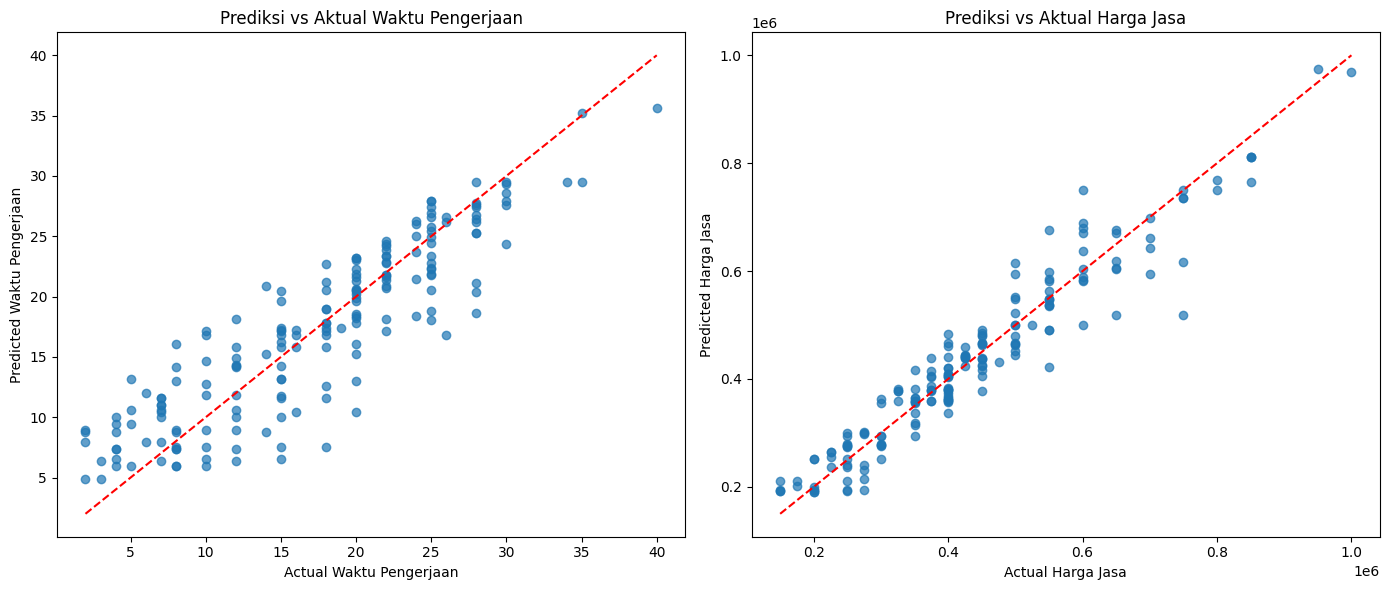

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: waktu_pengerjaan
axes[0].scatter(y_test_1, y_pred_1, alpha=0.7)
axes[0].set_xlabel('Actual Waktu Pengerjaan')
axes[0].set_ylabel('Predicted Waktu Pengerjaan')
axes[0].set_title('Prediksi vs Aktual Waktu Pengerjaan')
axes[0].plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], 'r--')

# Plot 2: harga_jasa
axes[1].scatter(y_test_2, y_pred_2, alpha=0.7)
axes[1].set_xlabel('Actual Harga Jasa')
axes[1].set_ylabel('Predicted Harga Jasa')
axes[1].set_title('Prediksi vs Aktual Harga Jasa')
axes[1].plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'r--')

plt.tight_layout()
plt.show()

In [37]:
# # Cross-validation dengan RMSE
# rmse_scores = cross_val_score(pipe_ridge, X, y, cv=5, scoring='neg_root_mean_squared_error')
# rmse_scores = -rmse_scores

# print("RMSE per fold:", rmse_scores)
# print("RMSE rata-rata:", np.mean(rmse_scores))

In [38]:
# # Cross-validation dengan R2
# scores = cross_val_score(pipe_ridge, X, y, cv=5, scoring='r2')

# print("R2 per fold:", scores)
# print("R2 rata-rata:", np.mean(scores))

### Prediksi

In [39]:
# # Standar deviasi error Ridge (log waktu & harga langsung)
# harga_std = np.std(y_test['harga_jasa'] - y_pred_ridge[:, 0])
# waktu_std = np.std(y_test['waktu_pengerjaan'] - y_pred_ridge[:, 1])

In [40]:
def predict_price(pipe_ridge, model_input, bahan_input, ornamen_input):
    # Buat DataFrame input
    df_input = pd.DataFrame([{
        'model': model_input,
        'bahan': bahan_input,
        'ornamen': ornamen_input
    }])

    # Prediksi
    pred = pipe_ridge.predict(df_input)[0]
    waktu_mean = pred[0]
    harga_mean = pred[1]

    # Format hasil
    return (
        f"Estimasi waktu pengerjaan: {int(round(waktu_mean))} hari\n"
        f"Estimasi harga jasa: Rp{int(round(harga_mean)):,}"
    )

In [41]:
print("Hasil Prediksi:")
print(predict_price(pipe_ridge, "Kebaya Tradisional", "Brokat", "None"))

Hasil Prediksi:
Estimasi waktu pengerjaan: 9 hari
Estimasi harga jasa: Rp294,781


### Save Model

In [42]:
to_save = {
    'model_predict': pipe_ridge
    # 'waktu_std': waktu_std,
    # 'harga_std': harga_std
}

In [43]:
joblib.dump(to_save, 'C:/Users/Kayaki/ta_project/models/model_akhir.pkl')

['C:/Users/Kayaki/ta_project/models/model_akhir.pkl']

In [44]:
joblib.dump(to_save, 'D:/ta_project/models/model_akhir.pkl')

['D:/ta_project/models/model_akhir.pkl']